In [1]:
import pandas as pd
import numpy as np

def recall_from_pr_df(pr_df, precision_value=0.75):
    recalls_dict = {}
    classes = pr_df.family.unique()

    for cls in classes:
        cls_pr = pr_df[pr_df.family == cls]
        bins = cls_pr.range.unique()
        recalls_dict[cls] = {}

        for bin in bins[:-1]:
            cls_bin_pr = cls_pr[cls_pr.range == bin]
            precisions = cls_bin_pr.precision.values  # [2:-2]
            recalls = cls_bin_pr.recall.values  # [2:-2]

            # Sort by recalls
            sorted_indices = np.argsort(recalls)[::-1]
            precisions = precisions[sorted_indices]
            recalls = recalls[sorted_indices]

            # Traverse through sorted values and apply the new logic
            
            for i in range(len(precisions)):
                if precisions[i] >= precision_value:
                    if i == 0:
                        recall = recalls[i]
                    else:
                        recall = np.interp(
                            precision_value,
                            [precisions[i-1], precisions[i]],
                            [recalls[i-1], recalls[i]]
                        )
                    break
            else:
                # If no precision meets the target, use the last available recall
                recall = recalls[-1]

            recalls_dict[cls][bin] = recall

    return recalls_dict

In [7]:
data_dict = {'default_600_crop_01_lr_01_wd' : 8,
             'default_600_crop_01_lr_01_wd_20_peds_data' : 9,
             'default_600_crop_01_lr_01_wd_20_peds_data_loss_weight' : 9,
             'default_600_crop_01_lr_01_wd_20_peds_data_loss_weight_v2' : 11,
             #'default_600_crop_01_lr_20_peds_data' : 8
             'default_600_crop_01_lr_01_wd_20_peds_data_beta_0_gamma_0' : 8,
             'default_600_crop_01_lr_01_wd_20_peds_data_beta_1' : 14
             }

data_dict = {'default_600_crop_night_test' : 2}

pr = {}

for name, num_ep in data_dict.items():
    print (name, num_ep)
    pr[name] = [pd.read_csv(f"/home/b2b/arthur/git/codetr/work_dirs/{name}/NewEval_wi_night_ep{i}/outputs/all_kpis.tsv", sep = '\t') for i in range(num_ep)]




default_600_crop_night_test 2


In [8]:
target_pr = 0.9

recs = {}

for name, pr_sample in pr.items():
    recs[name] = [recall_from_pr_df(pr_sample[i], precision_value=target_pr) for i in range(len(pr_sample))]


default_600_crop_night_test_ep0
default_600_crop_night_test_ep1


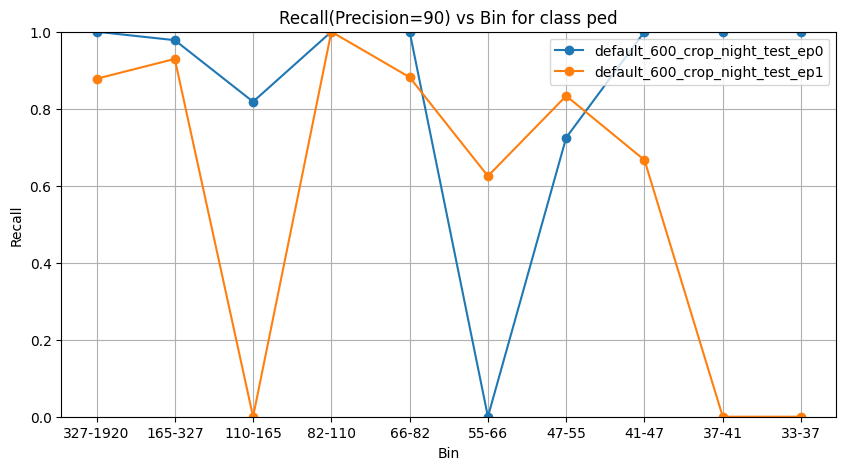

In [9]:
import matplotlib.pyplot as plt

cls = 'ped'


bins = {}
recalls = {}


for name, rec in recs.items():
    bins_data = [rec[i][cls] for i in range(data_dict[name])]
    bins[name] = [bins_data[i].keys() for i in range(data_dict[name])]
    recalls[name] = [bins_data[i].values() for i in range(data_dict[name])]

plt.figure(figsize=(10, 5))

plot_dict = {'default_600_crop_01_lr_01_wd' : [],
             #'default_600_crop_01_lr_01_wd_20_peds_data' : [6],
             #'default_600_crop_01_lr_01_wd_20_peds_data_loss_weight' : [7],
             #'default_600_crop_01_lr_01_wd_20_peds_data_loss_weight_v2' : [1],
             #'default_600_crop_01_lr_20_peds_data' : []
              'default_600_crop_01_lr_01_wd_20_peds_data_beta_0_gamma_0' : [1],
              'default_600_crop_01_lr_01_wd_20_peds_data_beta_1' : [13]
             }

plot_dict = {'default_600_crop_night_test' : [0, 1]}

#plt.plot(bins['default_600_crop_01_lr_01_wd'][0], recalls['default_600_crop_01_lr_01_wd'][0], marker='o', linestyle='-', label = 'default', color = 'black')

for name, indices in plot_dict.items():
    for i in indices:
        label = f'{name}_ep{i}'
        print (label)
        plt.plot(bins[name][i], recalls[name][i], marker='o', linestyle='-', label = label)

plt.xlabel('Bin')
plt.ylabel('Recall')
plt.title(f'Recall(Precision={int(target_pr*100)}) vs Bin for class {cls}')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


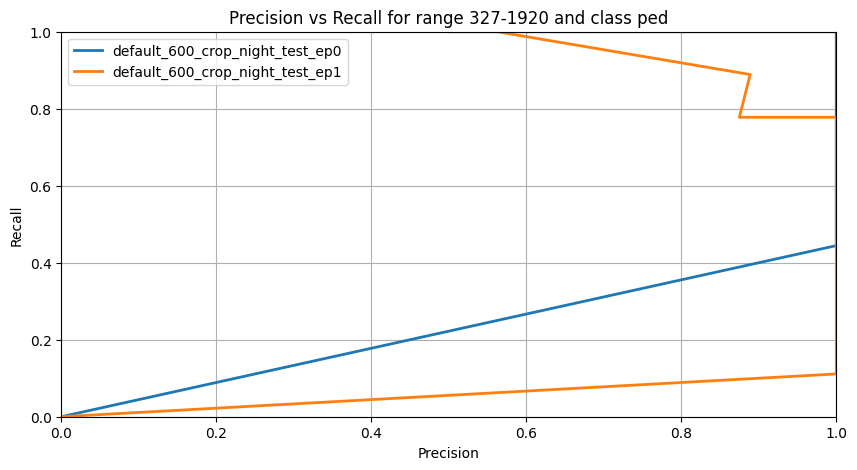

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


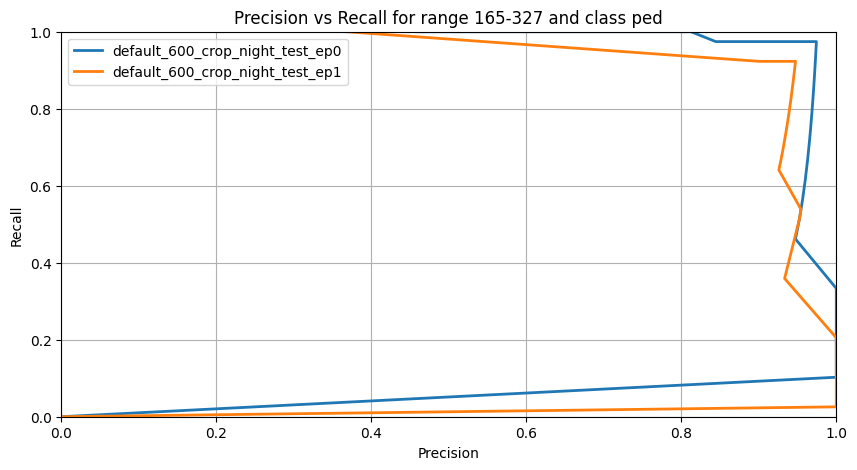

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


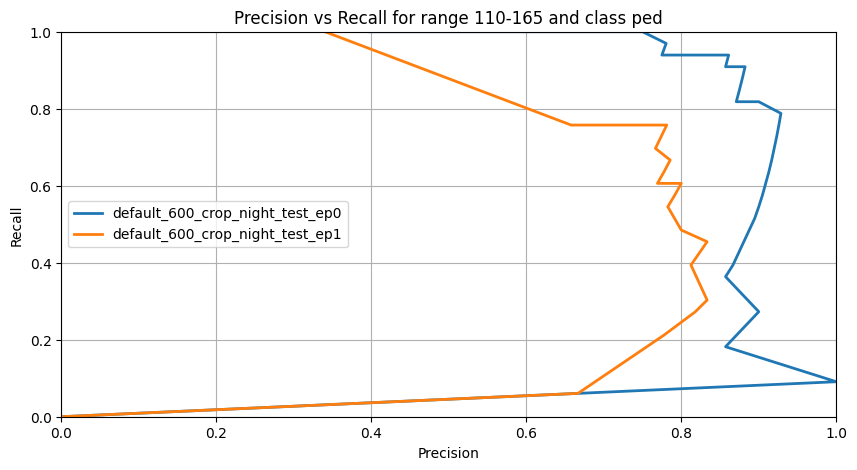

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


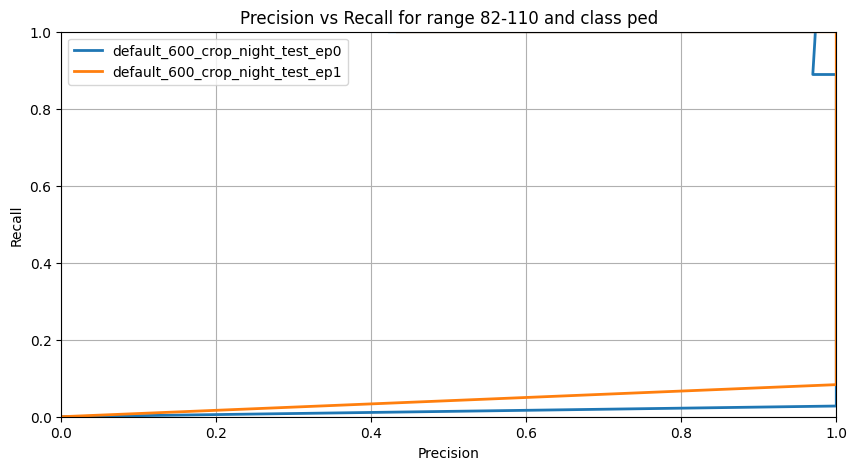

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


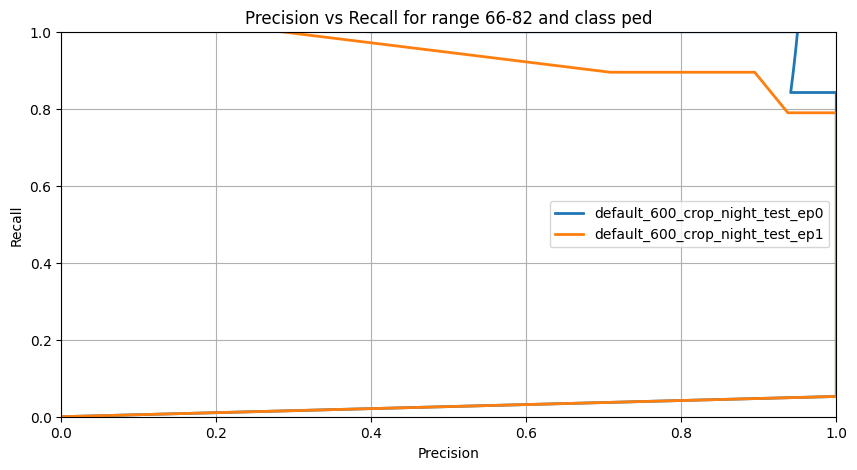

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


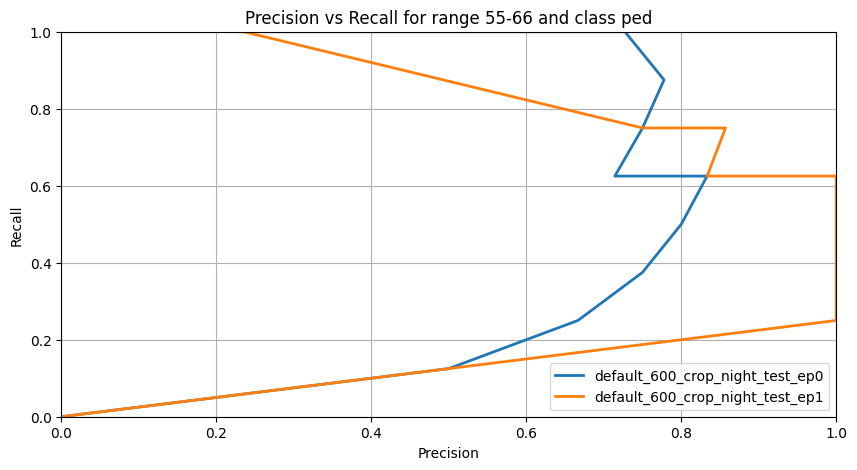

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


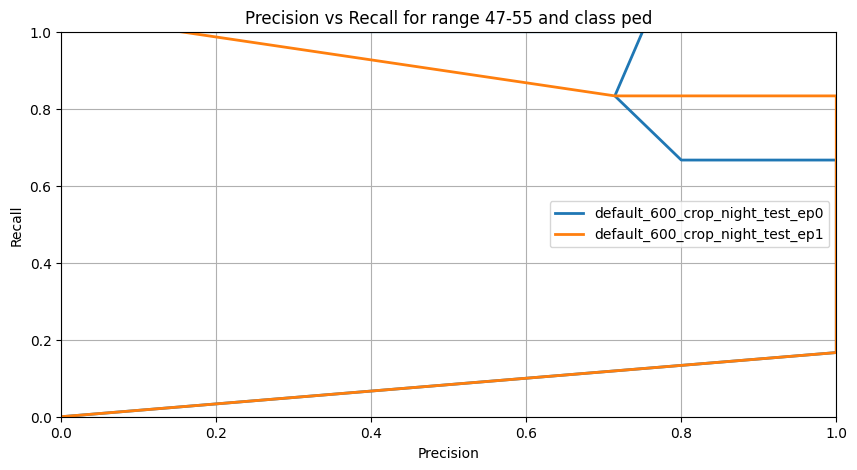

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


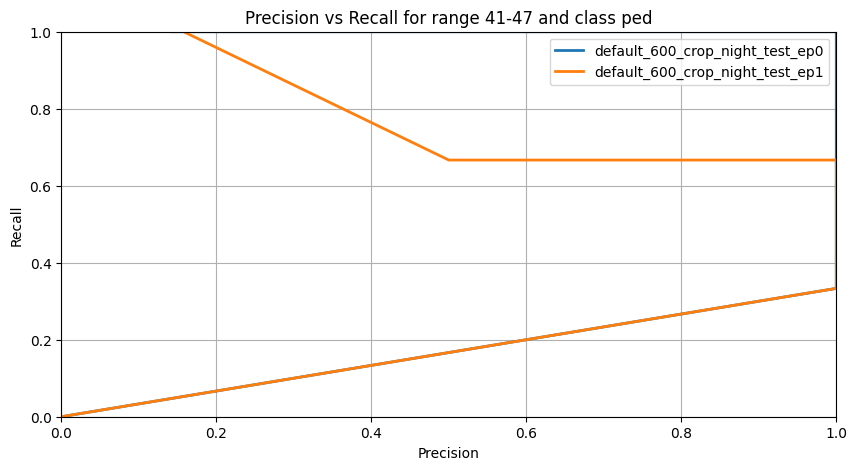

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


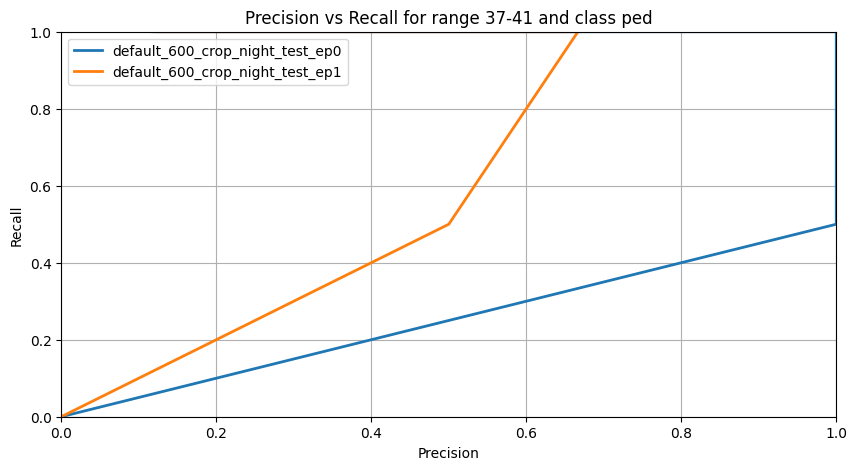

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


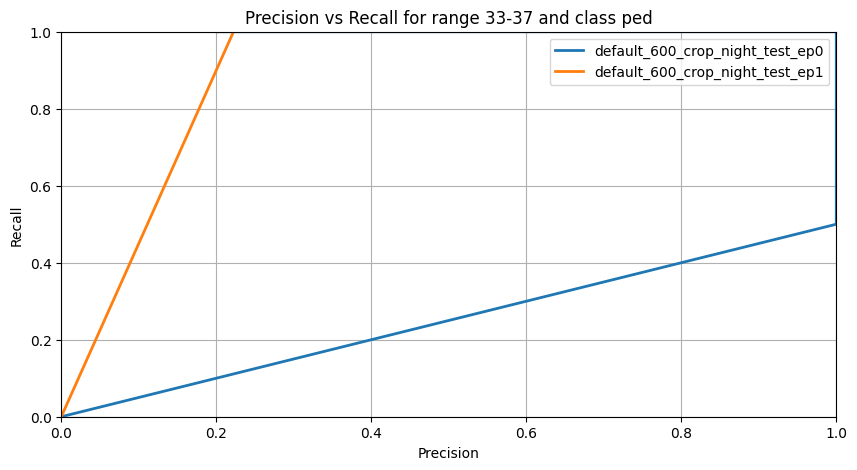

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


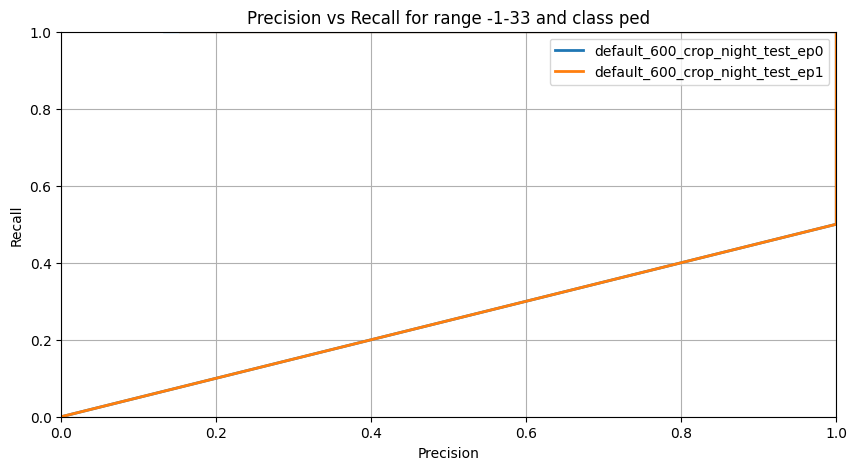

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Generate random colors for each threshold
thresholds_list = list(range(5, 101, 5))
threshold_colors = {threshold: (random.random(), random.random(), random.random()) for threshold in thresholds_list}

# Extract unique ranges from any experiment (assuming all experiments have the same ranges)
ranges = pr[list(pr.keys())[0]][0][pr[list(pr.keys())[0]][0].family == cls].range.unique()

# Iterate through all ranges
for rng in ranges:
    plt.figure(figsize=(10, 5))  # Create a new figure for each range
    
    # Default experiment plotting
    #name = 'default_600_crop_01_lr_01_wd'
    #precisions = pr[name][0][(pr[name][0].range == rng) & (pr[name][0].family == cls)].precision.values
    #recalls = pr[name][0][(pr[name][0].range == rng) & (pr[name][0].family == cls)].recall.values
    #thresholds = pr[name][0][(pr[name][0].range == rng) & (pr[name][0].family == cls)].threshold.values
    
    # Plot Precision vs Recall for default experiment
    #plt.plot(precisions, recalls, label=f'ep{0}', color='black')
    
    # Plot dots for specified thresholds on the curve
    #for threshold in thresholds_list:
    #    if threshold in thresholds:
    #        idx = list(thresholds).index(threshold)
    #        plt.plot(precisions[idx], recalls[idx], 'o', color=threshold_colors[threshold])  # Dots for default experiment
    
    # Iterate through the experiments specified in plot_dict
    for name, indices in plot_dict.items():
        for i in indices:
            # Filter data for the current range and class
            precisions = pr[name][i][(pr[name][i].range == rng) & (pr[name][i].family == cls)].precision.values
            recalls = pr[name][i][(pr[name][i].range == rng) & (pr[name][i].family == cls)].recall.values
            thresholds = pr[name][i][(pr[name][i].range == rng) & (pr[name][i].family == cls)].threshold.values
            
            # Plot Precision vs Recall for current experiment
            plt.plot(precisions, recalls, label=f'{name}_ep{i}', linewidth=2)
            
            print (thresholds_list)

            # Plot dots for specified thresholds on the curve
            #for threshold in thresholds_list:
            #    if threshold in thresholds:
            #        idx = list(thresholds).index(threshold)
            #        plt.plot(precisions[idx], recalls[idx], 'o', color=threshold_colors[threshold])  # Dots for current experiment
    
    # Set plot labels and title
    plt.ylabel('Recall')
    plt.xlabel('Precision')
    plt.title(f'Precision vs Recall for range {rng} and class {cls}')
    plt.legend()
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.grid(True)
    plt.show()



